## Часть 1. Исследование для сервиса Яндекс.Книги

- Автор: Болохова Ирина
- Дата: 07.08.2025

## Цели и задачи проекта



### Цель проекта:

Определить, права ли команда сервиса Яндекс.Книги в том, что пользователи из Санкт-Петербурга проводят в среднем больше времени за чтением и прослушиванием книг в приложении по сравнению с пользователями из Москвы, так как при расчётах среднего LTV было определено, что эта метрика у петербуржцев выше.


### Задачи проекта:

1. Загрузить данные пользователей и познакомиться с ними.
2. Проверить данные на наличие дубликатов.
3. Сравнить размеры групп и статистики для каждой группы.
4. Проверить гипотезу.
5. Подготовить аналитическую записку с интерпретацием результатов проверки гипотезы.

## Описание данных



В данном проекте используется таблица **yandex_knigi_data** с данными читательской активности пользователей Москвы и Санкт-Петербурга в сервисе Яндекс Книги, содержащая следующие поля:

- city — город или регион географического положения
- puid — идентификатор пользователя;
- hours — длительность чтения или прослушивания в часах для конкретного пользователя.

## Содержимое проекта



1. Загрузка данных и знакомство с ними.
2. Подготовка к А/В тестированию.
3. Проверка гипотезы в Python.
4. Аналитическая записка.
---

## 1. Загрузка данных и знакомство с ними



In [1]:
# Импортируем необходимые библиотеки
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, mannwhitneyu
from statsmodels.stats.power import NormalIndPower
from statsmodels.stats.proportion import proportion_effectsize

In [2]:
# Загрузим данные в датафрейм knigi_df 
knigi_df = pd.read_csv('https://code.s3.yandex.net///datasets/yandex_knigi_data.csv')

In [3]:
# Выведем первые строки датафрейма для ознакомления
knigi_df.head()

,Unnamed: 0,city,puid,hours
0,0,Москва,9668,26.167776
1,1,Москва,16598,82.111217
2,2,Москва,80401,4.656906
3,3,Москва,140205,1.840556
4,4,Москва,248755,151.326434


In [4]:
# Преобразуем столбец 'Unnamed: 0' в индекс
knigi_df = knigi_df.set_index('Unnamed: 0')
display(knigi_df)

,city,puid,hours
Unnamed: 0,,,
0,Москва,9668,26.167776
1,Москва,16598,82.111217
2,Москва,80401,4.656906
3,Москва,140205,1.840556
4,Москва,248755,151.326434
...,...,...,...
8779,Санкт-Петербург,1130000028554332,4.107774
8780,Санкт-Петербург,1130000030307246,45.069222
8781,Санкт-Петербург,1130000038726322,0.211944


In [5]:
# Выведем информацию о датафрейме
knigi_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8784 entries, 0 to 8783
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   city    8784 non-null   object 
 1   puid    8784 non-null   int64  
 2   hours   8784 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 274.5+ KB


Пропуски в данных отсутствуют, типы данных соответствуют данным.

In [6]:
# Проверим данные на наличие полных дубликатов
knigi_df.duplicated().sum() 

0

Получили, что в данных отсутсятвуют полные дубликаты. Проверим теперь дубликаты по идентификатору пользователей.

In [7]:
# Проверим данные на наличие дубликатов по идентификатору пользователей
knigi_df.duplicated(subset='puid').sum()

244

В данных содержатся 244 дубликата по идентификатору пользователя, проверим их, действительно ли они являются дубликатами.

In [8]:
# Сохраним дублирующиеся id пользователей и выведем данные датафрейма для этих пользователей
puids = knigi_df[knigi_df.duplicated(subset=['puid'])]['puid'].to_list()
knigi_df[knigi_df['puid'].isin(puids)].sort_values(by=['puid']).head(10)

,city,puid,hours
Unnamed: 0,,,
35,Москва,2637041,10.317371
6247,Санкт-Петербург,2637041,3.883926
134,Москва,9979490,32.415573
6274,Санкт-Петербург,9979490,1.302997
145,Москва,10597984,42.931506
6279,Санкт-Петербург,10597984,9.041320
150,Москва,10815097,9.086655
6283,Санкт-Петербург,10815097,0.323291
187,Москва,13626259,21.104167


По полученным данным видим, что для пользователей с одним и тем же id город прослушивания и время прослущивания отличаются, что вполне может логично обяснятся тем, что пользователь прослушивал книги в поездке в другой город.

Чтобы не исказить результаты последующнго тестирования из-за пересекающихся групп, такие дубликаты лучше удалить.

In [9]:
# Удалим найденные дубликаты
knigi_df = knigi_df.drop_duplicates(subset='puid', keep=False)
knigi_df.info()
knigi_df.duplicated(subset='puid').sum()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8296 entries, 0 to 8783
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   city    8296 non-null   object 
 1   puid    8296 non-null   int64  
 2   hours   8296 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 259.2+ KB


0

Данные очистили от дубликатов, теперь можно приступать к проверке данных для тестирования.

## 2. Подготовка к А/В-тестированию

При подготовке к проведению А/В тестированию необходимо сравнить размеры групп, их статистики и распределения.

In [10]:
# Посчитаем количество уникальных пользователей для каждой группы
knigi_df[knigi_df['city'] == 'Москва']['puid'].nunique(), knigi_df[knigi_df['city'] == 'Санкт-Петербург']['puid'].nunique() 

(5990, 2306)

In [11]:
# Посчитаем, в каком процентном отношении находятся группы
(100 * knigi_df[knigi_df['city'] == 'Москва']['puid'].nunique() / knigi_df['puid'].nunique(), 
 100 * knigi_df[knigi_df['city'] == 'Санкт-Петербург']['puid'].nunique() / knigi_df['puid'].nunique())

(72.20347155255544, 27.79652844744455)

Видим, что данные неравномерно распределены по группам: **72%** в Москве против **28%** в Санкт-Петербурге.

Учитывая эту неравномерность выборок, будем использовать **тест Манна-Уитни**, который не зависит от равномерности размера выборок.

В тестировании будет проверятся гипотеза о том, что пользователи из **Санкт-Петербурга** проводят в среднем **больше времени** за чтением и прослушиванием книг в приложении, чем пользователи из **Москвы**.

Поэтому расчитаем среднюю активность пользователей для каждого города.

In [12]:
# Рассчитаем среднюю активность пользователей для каждого города
time_mean = knigi_df.groupby('city').hours.mean() 
display(time_mean)

city
Москва             10.848192
Санкт-Петербург    11.264433
Name: hours, dtype: float64

По полученным значениям видим, что среднее время прослушивания книг в **Санкт-Петербурге немного больше, чем в Москве**, не смотря на меньшее количество пользователей.

Теперь приступим к проверке гипотезы.

## 3. Проверка гипотезы в Python

Гипотеза звучит так: пользователи из Санкт-Петербурга проводят в среднем больше времени за чтением и прослушиванием книг в приложении, чем пользователи из Москвы. Попробуйте статистически это доказать, используя одностороннюю проверку гипотезы с двумя выборками:

- Нулевая гипотеза H₀: Средняя активность пользователей в часах в двух группах (Москва и Санкт-Петербург) не различается.

- Альтернативная гипотеза H₁: Средняя активность пользователей в Санкт-Петербурге больше, и это различие статистически значимо.

Так как выбоки по городам получились неравномерные, будем использовать тест Манна-Уитни, который не зависит от равномерности размера выборок.

- Нулевая гипотеза **Н0**: Dist(XA)=Dist(XB) - распределение количества часов прослушанных книг в *группе А (Москва)* и в *группе В (Санкт-Петербург)* не различается.
- Альтернативная гипотеза **Н1**: Dist(XA)<Dist(XB) - распределение количества часов прослушанной музыки в *группе В (Санкт-Петербург)* больше, чем в *группе А (Москва)*.

In [13]:
# Выборка целевой метрики для группы A
metric_a = knigi_df[knigi_df['city'] == 'Москва'].hours 
# Выборка целевой метрики для группы B
metric_b = knigi_df[knigi_df['city'] == 'Санкт-Петербург'].hours 

# На каком уровне значимости проверяем гипотезу о равенстве распределений
alpha = 0.05 

# Применяем тест Манна — Уитни
stat_mw, p_value_mw = mannwhitneyu(
    metric_a, 
    metric_b, 
    alternative='less' # Альтернативная гипотеза односторонняя
) 

if p_value_mw > alpha:
    print(f'pvalue={p_value_mw} > {alpha}')
    print('Нулевая гипотеза находит подтверждение!')
else:
    print(f'pvalue={p_value_mw} < {alpha}')
    print('Нулевая гипотеза не находит подтверждения!')

pvalue=0.4532273739367588 > 0.05
Нулевая гипотеза находит подтверждение!


Поскольку p-value = 0.4532273739367588 **выше** уровня значимости, значит, мы попадаем в область принятия нулевой гипотезы. 

На основании полученного значения p-value можем сделать вывод, что распределения метрики в группах A и B **не различаются**. 
Это означает, что средняя активность в часах пользователей в Москве и Санкт-Петербурге **не различается**.

## 4. Аналитическая записка
По результатам анализа данных подготовьте аналитическую записку, в которой опишете:

- Выбранный тип t-теста и уровень статистической значимости.

- Результат теста, или p-value.

- Вывод на основе полученного p-value, то есть интерпретацию результатов.

- Одну или две возможные причины, объясняющие полученные результаты.



На основании проведённого непараметрического **теста Манна-Уитни** с уровнем значимости **α = 0.05** получены следующие результаты:

p-value = 0.453 (значительно > 0.05)

**Статистический вывод:**
Нулевая гипотеза **не отвергается**. Это означает, что статистически значимых различий в распределении времени активности между группами Москвы и Санкт-Петербурга **не обнаружено**, то есть активность пользователей в обоих городах **не различается** и  команда сервиса Яндекс.Книги оказалась не права в том, что пользователи из Санкт-Петербурга проводят в среднем больше времени за чтением и прослушиванием книг в приложении по сравнению с пользователями из Москвы.

Возможной **причиной** полученных результатов может являться то, что разницы в поведении пользователей между городами действительно нет. 

----

## Часть 2. Анализ результатов A/B-тестирования для интернет-магазина BitMotion Kit

Теперь необходимо проанализировать другие данные. К нам обратились представители интернет-магазина BitMotion Kit, в котором продаются геймифицированные товары для тех, кто ведёт здоровый образ жизни. У него есть своя целевая аудитория, даже появились хиты продаж: эспандер со счётчиком и напоминанием, так и подстольный велотренажёр с Bluetooth.

В будущем компания хочет расширить ассортимент товаров. Но перед этим нужно решить одну проблему. Интерфейс онлайн-магазина слишком сложен для пользователей — об этом говорят отзывы.

Чтобы привлечь новых клиентов и увеличить число продаж, владельцы магазина разработали новую версию сайта и протестировали его на части пользователей. По задумке, это решение доказуемо повысит количество пользователей, которые совершат покупку.

Задача — провести оценку результатов A/B-теста. В нашем распоряжении:

* данные о действиях пользователей и распределении их на группы,

* техническое задание.

Необходимо оценить корректность проведения теста и проанализировать его результаты.

## 1. Опишите цели исследования.



Цель исследования — оценить, насколько корректно проведен А/В тест и его результаты для анализа новой версии онлайн-магазина BitMotion Kit с геймифицированными товарами для людей, ведущих здоровый образ жизни.

## 2. Загрузите данные, оцените их целостность.


In [41]:
# Загрузим данные
participants = pd.read_csv('https://code.s3.yandex.net/datasets/ab_test_participants.csv')
events = pd.read_csv('https://code.s3.yandex.net/datasets/ab_test_events.zip',
                     parse_dates=['event_dt'], low_memory=False)

In [15]:
# Выведем первые строки датафрейма participants
participants.head()

,user_id,group,ab_test,device
0,0002CE61FF2C4011,B,interface_eu_test,Mac
1,001064FEAAB631A1,B,recommender_system_test,Android
2,001064FEAAB631A1,A,interface_eu_test,Android
3,0010A1C096941592,A,recommender_system_test,Android
4,001E72F50D1C48FA,A,interface_eu_test,Mac


Видим, что данные в этом датафрейме содержат следующие поля:
- user_id — идентификатор пользователя;
- group — группа пользователя;
- ab_test — название теста;
- device — устройство, с которого происходила регистрация.

In [16]:
# Проверим на наличие явных дубликатов
participants.duplicated().sum()

0

Явные дубликаты в датафрейме отсутствуют.

In [17]:
# Выведем информацию о датафрейме participants
participants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14525 entries, 0 to 14524
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  14525 non-null  object
 1   group    14525 non-null  object
 2   ab_test  14525 non-null  object
 3   device   14525 non-null  object
dtypes: object(4)
memory usage: 454.0+ KB


Данные содержат 14525 строк, пропуски отсутствуют.

In [42]:
# Выведем первые строки датафрейма events
events.head()

,user_id,event_dt,event_name,details
0,GLOBAL,2020-12-01 00:00:00,End of Black Friday Ads Campaign,ZONE_CODE15
1,CCBE9E7E99F94A08,2020-12-01 00:00:11,registration,0.0
2,GLOBAL,2020-12-01 00:00:25,product_page,NaN
3,CCBE9E7E99F94A08,2020-12-01 00:00:33,login,NaN
4,CCBE9E7E99F94A08,2020-12-01 00:00:52,product_page,NaN


Видим, что данные в этом датафрейме содаржат следующие поля:
- user_id — идентификатор пользователя;
- event_dt — дата и время события;
- event_name — тип события;
- details — дополнительные данные о событии.

In [43]:
# Выведем информацию о датафрейме events
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 787286 entries, 0 to 787285
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     787286 non-null  object        
 1   event_dt    787286 non-null  datetime64[ns]
 2   event_name  787286 non-null  object        
 3   details     249022 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 24.0+ MB


In [44]:
# Проверим на наличие дубликатов по столбцам user_id, event_dt и event_name
events.duplicated(subset = ['user_id','event_name','event_dt']).sum()

39510

Данные содержат 787286 строк, пропуски есть только в столбце `details`, а также данные содержат 39510 дубликатов по пользователю, дате события и названию события.

Удалим найденные дубликаты.

In [45]:
# Удалим дубликаты
events = events.drop_duplicates(subset = ['user_id','event_name','event_dt']).reset_index(drop=True)

In [46]:
events.duplicated(subset = ['user_id','event_name','event_dt']).sum()

0

Дубликаты по событиям удалены, можно приступать к оценке корректности теста.

## 3. По таблице `ab_test_participants` оцените корректность проведения теста:

   3\.1 Выделите пользователей, участвующих в тесте, и проверьте:

   - соответствие требованиям технического задания,

   - равномерность распределения пользователей по группам теста,

   - отсутствие пересечений с конкурирующим тестом (нет пользователей, участвующих одновременно в двух тестовых группах).

In [23]:
# Выделим пользователей, участвующих в тесте interface_eu_test
i_test_participants = participants[participants['ab_test'] == 'interface_eu_test']
display(i_test_participants)

,user_id,group,ab_test,device
0,0002CE61FF2C4011,B,interface_eu_test,Mac
2,001064FEAAB631A1,A,interface_eu_test,Android
4,001E72F50D1C48FA,A,interface_eu_test,Mac
5,002412F1EB3F6E38,B,interface_eu_test,Mac
6,002540BE89C930FB,B,interface_eu_test,Android
...,...,...,...,...
14519,FFE600EEC4BA7685,B,interface_eu_test,Android
14520,FFE7FC140521F5F6,A,interface_eu_test,PC
14521,FFEFC0E55C1CCD4F,A,interface_eu_test,PC
14523,FFF28D02B1EACBE1,B,interface_eu_test,PC


In [24]:
# Посчитаем количество пользователей в каждой группе теста
[count_users_A, count_users_B] = (i_test_participants[i_test_participants['group'] == 'A']['user_id'].nunique(),
                                  i_test_participants[i_test_participants['group'] == 'B']['user_id'].nunique())
display(count_users_A, count_users_B)

5383

5467

In [47]:
#Расчитаем разницу в процентах в количестве пользователей в группах A и B
from math import fabs

P = round(100 * (fabs(count_users_A - count_users_B) / count_users_A), 2)
print(f'Процентная разница между группами А и В составляет {P}%')

Процентная разница между группами А и В составляет 1.56%


Разница между количеством участников тестирования в группах А и В небольшая и составляет всего **1.56%**. Распределение можно считать равномерным.

Посмотрим на распределение участников в группах по категориям используемых устройств.

<Figure size 864x360 with 0 Axes>

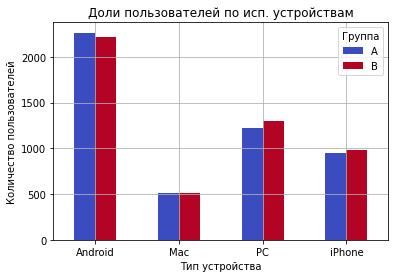

In [48]:
#Построим диаграмму распределения количества пользователей групп А и В по типам используемых устройств
user_by_device = i_test_participants.groupby(['device', 'group'])['user_id'].nunique()

plt.figure(figsize=(12, 5)) # Создаём контейнер графика matplotlib и задаём его размер

# Строим столбчатую диаграмму с помощью pandas через plot(kind='bar')
user_by_device.unstack().plot(
               kind='bar', # Тип графика - столбчатая диаграмма
               rot=0, # Градус вращения подписи по оси Х
               title=f'Доли пользователей по исп. устройствам',
               colormap='coolwarm'
)

# Настраиваем оформление графика
plt.xlabel('Тип устройства')
plt.ylabel('Количество пользователей')
# Включаем легенду
plt.legend(title='Группа')
# Добавляем сетку графика
plt.grid()

# Выводим график
plt.show()


По полученному графику видим, что количество пользователей, использующих различные типы устройств в группах А и В, примерно **одинаково**.

In [27]:
# Проверим отсутствие пересечений с конкурирующим тестом
group_i_test = participants[participants['ab_test'] == 'interface_eu_test']['user_id']
group_r_s_test = participants[participants['ab_test'] == 'recommender_system_test']['user_id']

intersection = set(group_i_test) & set(group_r_s_test)
count = len(intersection)

print(f'Пересекающиеся элементы: {intersection}')  
print(f'Количество пересечений: {count}')

Пересекающиеся элементы: {'6A2064F288EF094F', '0C2E77C6A381704A', '0A0141A363E2E051', 'D7933558E33BF7D5', '48BEDF1889241425', '6D54D48C640D27D3', '7F2C298110AA73B4', '9E0A3633886C080E', 'E7F4B5EBC0495D72', 'A2212CF79158D340', '74EEC94A70685C1E', '2A12B7DB3C6E84D6', '944C88D5DF108AED', 'A9E0A8057A5F07D1', '4E43940B0CF8D947', 'A8C57C0D4118F4D7', '72742C5F312A1FEC', '505555B3CCA490C8', '91E39AA34D6D1173', 'E1489CCA162BC2E6', '40194A2E6C03B547', '147C62E5B82E2EA9', '934134714E66295F', '0D6F5E157A56FB00', 'CC705D51C74418AD', 'B60B4563ADC259E3', '5650B53B91DC98BB', '783A96FF14C40478', 'EEF5EFB2D5915CF1', '06D2B163CB560FAC', 'FEC0BCA6C323872F', 'ECC76B90EB71C492', 'E18D25D68D9FCC60', 'AFFC4117AC279D49', '64E7466FBB579E9E', 'DA8DABF19A0203FD', '9CBD8387C8A1DDDF', '71A21F6C17C665C6', '6E3E5F88B6A3B401', 'C21237DC47AE00C5', '1CC27A00D4907AAB', '64CD9350DEEE01B6', 'AA5A1803D3FA76B4', 'C1760622B65C9B84', '47ADBF580CF107E1', 'BD23AF6242CA944B', 'D40A89E14F1C10BD', '60A6101325BBA47E', 'CA6F4DAED160E

Получилось, что 887 пользователей участвуют в обоих тестированиях.

Чтобы исключить влияние конкурирующего тестирования, удалим пересекающихся пользователей.

In [28]:
participants = participants[~participants['user_id'].isin(intersection)] 

In [29]:
# ПРоверим на пересечение пользователей в группах А и В
i_test_participants = participants[participants['ab_test'] == 'interface_eu_test']
group_a = i_test_participants[i_test_participants['group'] == 'A']['user_id']
group_b = i_test_participants[i_test_participants['group'] == 'B']['user_id']

intersection = set(group_a) & set(group_b)
count = len(intersection)

print(f'Пересекающиеся элементы: {intersection}')  
print(f'Количество пересечений: {count}')

Пересекающиеся элементы: set()
Количество пересечений: 0


Пересечений между группами нет.

3\.2 Проанализируйте данные о пользовательской активности по таблице `ab_test_events`:

- оставьте только события, связанные с участвующими в изучаемом тесте пользователями;

In [49]:
# Объединим таблицы и оставим только пользователей, участвующих в тестировании
filtered_events = events.merge(i_test_participants, 
                       left_on='user_id',
                       right_on='user_id',
                       how='inner')
display(filtered_events)

,user_id,event_dt,event_name,details,group,ab_test,device
0,5F506CEBEDC05D30,2020-12-06 14:10:01,registration,0.0,A,interface_eu_test,iPhone
1,5F506CEBEDC05D30,2020-12-07 01:25:14,login,NaN,A,interface_eu_test,iPhone
2,5F506CEBEDC05D30,2020-12-07 01:25:47,login,NaN,A,interface_eu_test,iPhone
3,5F506CEBEDC05D30,2020-12-09 12:40:49,login,NaN,A,interface_eu_test,iPhone
4,5F506CEBEDC05D30,2020-12-09 12:40:49,product_page,NaN,A,interface_eu_test,iPhone
...,...,...,...,...,...,...,...
67577,16CCB1C8C4DCF1AF,2020-12-23 23:50:29,registration,0.0,A,interface_eu_test,Mac
67578,16CCB1C8C4DCF1AF,2020-12-23 23:55:52,login,NaN,A,interface_eu_test,Mac
67579,2DDC948BD76ABC57,2020-12-24 21:57:10,registration,-4.29,B,interface_eu_test,iPhone
67580,2DDC948BD76ABC57,2020-12-24 21:58:49,login,NaN,B,interface_eu_test,iPhone


- определите горизонт анализа: рассчитайте время (лайфтайм) совершения события пользователем после регистрации и оставьте только те события, которые были выполнены в течение первых семи дней с момента регистрации;

In [50]:
# Создаем отдельный датафрейм с датами регистрации
registrations = (filtered_events[filtered_events['event_name'] == 'registration'][['user_id', 'event_dt']]
    .rename(columns={'event_dt': 'registration_date'}).drop_duplicates('user_id', keep='first'))

# Объединяем с основным датафреймом
filtered_events = filtered_events.merge(registrations, on='user_id', how='left')

# Вычисляем разницу в днях
filtered_events['days_since_registration'] = (filtered_events['event_dt'] - filtered_events['registration_date']).dt.days
display(filtered_events)

,user_id,event_dt,event_name,details,group,ab_test,device,registration_date,days_since_registration
0,5F506CEBEDC05D30,2020-12-06 14:10:01,registration,0.0,A,interface_eu_test,iPhone,2020-12-06 14:10:01,0
1,5F506CEBEDC05D30,2020-12-07 01:25:14,login,NaN,A,interface_eu_test,iPhone,2020-12-06 14:10:01,0
2,5F506CEBEDC05D30,2020-12-07 01:25:47,login,NaN,A,interface_eu_test,iPhone,2020-12-06 14:10:01,0
3,5F506CEBEDC05D30,2020-12-09 12:40:49,login,NaN,A,interface_eu_test,iPhone,2020-12-06 14:10:01,2
4,5F506CEBEDC05D30,2020-12-09 12:40:49,product_page,NaN,A,interface_eu_test,iPhone,2020-12-06 14:10:01,2
...,...,...,...,...,...,...,...,...,...
67577,16CCB1C8C4DCF1AF,2020-12-23 23:50:29,registration,0.0,A,interface_eu_test,Mac,2020-12-23 23:50:29,0
67578,16CCB1C8C4DCF1AF,2020-12-23 23:55:52,login,NaN,A,interface_eu_test,Mac,2020-12-23 23:50:29,0
67579,2DDC948BD76ABC57,2020-12-24 21:57:10,registration,-4.29,B,interface_eu_test,iPhone,2020-12-24 21:57:10,0
67580,2DDC948BD76ABC57,2020-12-24 21:58:49,login,NaN,B,interface_eu_test,iPhone,2020-12-24 21:57:10,0


In [51]:
# Отфильтуем события, которые выполнены в течении семи дней с момента регистрации
filtered_events_week = filtered_events[(filtered_events['days_since_registration']>0) & (filtered_events['days_since_registration']<=7)]
display (filtered_events_week)

,user_id,event_dt,event_name,details,group,ab_test,device,registration_date,days_since_registration
3,5F506CEBEDC05D30,2020-12-09 12:40:49,login,NaN,A,interface_eu_test,iPhone,2020-12-06 14:10:01,2
4,5F506CEBEDC05D30,2020-12-09 12:40:49,product_page,NaN,A,interface_eu_test,iPhone,2020-12-06 14:10:01,2
5,5F506CEBEDC05D30,2020-12-10 23:18:00,product_page,NaN,A,interface_eu_test,iPhone,2020-12-06 14:10:01,4
9,51278A006E918D97,2020-12-09 02:12:06,product_cart,NaN,A,interface_eu_test,Android,2020-12-06 14:37:25,2
10,51278A006E918D97,2020-12-09 02:13:52,product_cart,NaN,A,interface_eu_test,Android,2020-12-06 14:37:25,2
...,...,...,...,...,...,...,...,...,...
67540,2AF75C1818C73A66,2020-12-28 11:08:27,product_page,NaN,A,interface_eu_test,PC,2020-12-23 23:30:23,4
67541,2AF75C1818C73A66,2020-12-28 11:09:19,purchase,8.99,A,interface_eu_test,PC,2020-12-23 23:30:23,4
67542,2AF75C1818C73A66,2020-12-28 11:10:50,purchase,4.49,A,interface_eu_test,PC,2020-12-23 23:30:23,4
67551,0E56FC327DD4DA1F,2020-12-27 07:37:23,product_page,NaN,A,interface_eu_test,Android,2020-12-23 23:34:21,3


Оцените достаточность выборки для получения статистически значимых результатов A/B-теста. Заданные параметры:

- базовый показатель конверсии — 30%,

- мощность теста — 80%,

- достоверность теста — 95%.

In [52]:
# Задаём параметры
alpha = 0.05  # Уровень значимости
power = 0.8  # Мощность теста
p = 0.3 # Базовый уровень доли
mde = 0.1 * p  # Минимальный детектируемый эффект
effect_size = proportion_effectsize(p, p + mde)

# Инициализируем класс NormalIndPower
power_analysis = NormalIndPower()

# Рассчитываем размер выборки
sample_size = power_analysis.solve_power(
    effect_size = effect_size,
    power = power,
    alpha = alpha,
    ratio = 1 # Равномерное распределение выборок
)

print(f"Необходимый размер выборки для каждой группы: {int(sample_size)}")

Необходимый размер выборки для каждой группы: 3761


In [53]:
# Проверим количество участников в каждой группе после фильтрации данных.
[count_A, count_B] = (filtered_events_week[filtered_events_week['group'] == 'A']['user_id'].nunique(),
                                  filtered_events_week[filtered_events_week['group'] == 'B']['user_id'].nunique())
display(count_A, count_B)

3773

3870

По полученным данным видим, что в обеих группах тестирования содержится достаточное количество участников.

- рассчитайте для каждой группы количество посетителей, сделавших покупку, и общее количество посетителей.

In [54]:
# Расчитаем количество уникальных посетителей, совершивших покупки, в каждой из групп
purchase_A = filtered_events_week[(filtered_events_week['event_name']=='purchase')&(filtered_events_week['group']=='A')]['user_id'].nunique()
purchase_B = filtered_events_week[(filtered_events_week['event_name']=='purchase')&(filtered_events_week['group']=='B')]['user_id'].nunique()
display(purchase_A, purchase_B)

1188

1311

- сделайте предварительный общий вывод об изменении пользовательской активности в тестовой группе по сравнению с контрольной.

In [55]:
# Посчитаем конверсию в покупку для каждой из групп 
conversion_A = round(100 * purchase_A / count_A, 2)
conversion_B = round(100 * purchase_B / count_B, 2)
display(conversion_A, conversion_B)

31.49

33.88

In [56]:
# Посчитаем разницу конверсий групп А и В
round(conversion_A - conversion_B, 2)

-2.39

По полученным данным видим, что конверсия в группе В (с новым дизайном страницы онлайн-магазина) **больше**, чем в группе А (со старой версией страницы онлайн-магазина) **на 2.39 процентных пункта**.

## 4. Проведите оценку результатов A/B-тестирования:

- Проверьте изменение конверсии подходящим статистическим тестом, учитывая все этапы проверки гипотез.

Для проверки статистической значимости ролученной разницы в конверсиях групп А и В будем использовать **Z-тест пропорций**.

Сформулируем гипотезы:
- **Нулевая гипотеза H0**: pA = pB - конверсия зарегистрированных пользователей в покупателей **одинакова** в группах А и В.
- **Альтернативная гипотеза H1**: pA < pB  - конверсия зарегистрированных пользователей в покупателей **в группе B выше, чем в группе A**.

Проверка на непересечение групп уже была выполнена ранее, перечений не найдено. 

Проверим, выполняется ли предпосылка Z-теста пропорций о достаточном размере выборок. Для этого посчитаем количество наблюдений в каждой группе, а также — количество «успехов» в них (то есть факт покупки). Убедимся, что условия для проведения теста выполнены.

In [57]:
n_a, n_b = (filtered_events_week[filtered_events_week.group=='A'].shape[0],
            filtered_events_week[filtered_events_week.group=='B'].shape[0]) ## размеры выборок A и B
m_a = filtered_events_week[(filtered_events_week.group=='A')&(filtered_events_week.event_name=='purchase')].shape[0] # количество успехов (регистраций) в группе A
m_b = filtered_events_week[(filtered_events_week.group=='B')&(filtered_events_week.event_name=='purchase')].shape[0] # количество успехов (регистраций) в группе B

p_a, p_b = m_a/n_a, m_b/n_b # рассчитываем доли успехов для каждой группы: A и B

print(f'n_a={n_a}, n_b={n_b}')

print(f'm_a={m_a}, m_b={m_b}')

print(f'p_a={p_a}, p_b={p_b}')

if (p_a*n_a > 10)and((1-p_a)*n_a > 10)and(p_b*n_b > 10)and((1-p_b)*n_b > 10):
    print('Предпосылка о достаточном количестве данных выполняется!')
else:
    print('Предпосылка о достаточном количестве данных НЕ выполняется!')

n_a=12401, n_b=13363
m_a=2286, m_b=3029
p_a=0.18433997258285623, p_b=0.2266706577864252
Предпосылка о достаточном количестве данных выполняется!


In [58]:
# Применим Z-тест пропорций
from statsmodels.stats.proportion import proportions_ztest

alpha = 0.05 ## на каком уровне значимости проверяем гипотезу о равенстве вероятностей

stat_ztest, p_value_ztest = proportions_ztest(
    [m_a, m_b],
    [n_a, n_b],
    alternative='smaller' # так как H_1: p_a < p_b
)
p_value_ztest

if p_value_ztest > alpha:
    print(f'pvalue={p_value_ztest} > {alpha}')
    print('Нулевая гипотеза находит подтверждение!')
else:
    print(f'pvalue={p_value_ztest} < {alpha}')
    print('Нулевая гипотеза не находит подтверждения!')

pvalue=2.43364881586486e-17 < 0.05
Нулевая гипотеза не находит подтверждения!


- Опишите выводы по проведённой оценке результатов A/B-тестирования. Что можно сказать про результаты A/B-тестирования? Был ли достигнут ожидаемый эффект в изменении конверсии?

В результате применения Z-теста для проверки гипотезы, получили значение p-value, которое очень близко к нулю.Это означает, что **нет оснований принимать нулевую гипотезу**. **Альтернативная гипотеза**, согласно результатам статистического теста, **находит подтверждение**.

Таким образом, можно сделать вывод, что **существует статистически значимое различие** между конверсиями зарегистрированных пользователей в покупателей в группах A и B. 

В рамках альтернативной гипотезы мы предполагали, что в группе B (с обновленным дизайном страницы онлайн-магазина) конверсия будет выше. Результаты подтверждают это: **конверсия зарегистрированных пользователей в покупателей в группе В выше, чем в группе А на 2.39 процентных пункта**. 

Предположение владельца онлайн-магазина BitMotion Kit о том, что в течение семи дней после регистрации в системе конверсия зарегистрированных пользователей в покупателей увеличится как минимум на три процентных пункта, оказалось **частично верным** (ожидалось повышение не менее, чем на 3 процентных пункта).